## Description
The objective of this competition is to create a machine learning model to detect fraudulent transactions.

Fraud detection is an important application of machine learning in the financial services sector. This solution will help Xente provide improved and safer service to its customers.

This competition is sponsored by Xente, Innovation Village, and insight2impact.

## Data
Xente is an e-commerce and financial service app serving 10,000+ customers in Uganda.

This dataset includes a sample of approximately 140,000 transactions that occurred between 15 November 2018 and 15 March 2019.

One of the challenges of fraud detection problems is that the data is highly imbalanced. 

## Evaluation
The error metric for this competition is the F1 score, which ranges from 0 (total failure) to 1 (perfect score). Hence, the closer your score is to 1, the better your model.

-F1 Score: A performance score that combines both precision and recall. It is a harmonic mean of these two variables. 
Formula is given as: 2*Precision*Recall/(Precision + Recall)

-Precision: This is an indicator of the number of items correctly identified as positive out of total items identified as positive.
Formula is given as: TP/(TP+FP)

-Recall / Sensitivity / True Positive Rate (TPR): This is an indicator of the number of items correctly identified as positive out of total actual positives. 
Formula is given as: TP/(TP+FN)

Where:

TP=True Positive
FP=False Positive
TN=True Negative
FN=False Negative

In [1]:
!pip install plotly

You should consider upgrading via the '/Users/danielastuermer/neuefische/ds-ml-project/.venv/bin/python -m pip install --upgrade pip' command.


In [2]:
import pandas as pd
from datetime import datetime, date, time, timedelta
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# Load the variable names
variable_meanings = pd.read_csv("data/variable meanings.csv")
pd.set_option('max_colwidth', 800)
variable_meanings

,Column Name,Definition
0,TransactionId,Unique ï¿½transaction identifier on platform
1,BatchId,Unique number assigned to a batch of transactions for processing
2,AccountId,Unique number identifying the customer on platform
3,SubscriptionId,Unique number identifying the customer subscription
4,CustomerId,Unique identifier attached to Account
5,CurrencyCode,Country currency
6,CountryCode,Numerical geographical code of country
7,ProviderId,Source provider of Item ï¿½bought.
8,ProductId,Item name being bought.
9,ProductCategory,ProductIds are organized into these broader product categories.


## Results from Pandas Profile
1. There is only one CurrencyCode, that means there is no additional information provided by this feature ==> Drop CurrencyCode
2. There is only one CountryCode, that means there is no additional information provided by this feature ==> Drop CountryCode
3. TransactionIDs are all distinct, that means there is no additional information provided ==> Drop TransactionIds
4. TransactionStartTime consist of timestamps. For further analysis ==> group them into timeframes (use "datetime")
5. Amount contains + and - values (due to debit/credit) ==> We need to create a column with debit credit and transform "amount" to absolut values
6. Extremly imbalanced target value ==> We need to do Oversampling
7. Definition for column  CustomerID and AccountId seems to be mixed up
8. Transform variable value or value (log) due to skewness 

In [4]:
# Load the data
data_test = pd.read_csv("data/test.csv")
data_train = pd.read_csv("data/training.csv")


In [5]:
data_train.head()

,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,CurrencyCode,CountryCode,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,TransactionStartTime,PricingStrategy,FraudResult
0,TransactionId_76871,BatchId_36123,AccountId_3957,SubscriptionId_887,CustomerId_4406,UGX,256,ProviderId_6,ProductId_10,airtime,ChannelId_3,1000.0,1000,2018-11-15T02:18:49Z,2,0
1,TransactionId_73770,BatchId_15642,AccountId_4841,SubscriptionId_3829,CustomerId_4406,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-20.0,20,2018-11-15T02:19:08Z,2,0
2,TransactionId_26203,BatchId_53941,AccountId_4229,SubscriptionId_222,CustomerId_4683,UGX,256,ProviderId_6,ProductId_1,airtime,ChannelId_3,500.0,500,2018-11-15T02:44:21Z,2,0
3,TransactionId_380,BatchId_102363,AccountId_648,SubscriptionId_2185,CustomerId_988,UGX,256,ProviderId_1,ProductId_21,utility_bill,ChannelId_3,20000.0,21800,2018-11-15T03:32:55Z,2,0
4,TransactionId_28195,BatchId_38780,AccountId_4841,SubscriptionId_3829,CustomerId_988,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-644.0,644,2018-11-15T03:34:21Z,2,0


In [6]:
data_train.shape

(95662, 16)

---

## Data cleaning and creating new features

* Stripped the ID columns from non-integer characters and converted them to integers
* Separated TransactionStartTime into transactiontime and transactiondate
* Drop redundant columns

In [7]:
def remove_letters(string):
    return int(string.split('_')[1])
    
id_columns = ["TransactionId","BatchId","AccountId","SubscriptionId","CustomerId","ProviderId","ProductId","ChannelId"]    
for i in id_columns:
    data_train[i] = data_train[i].apply(lambda x:remove_letters(x))

In [8]:
# seperate `TransactionStartTime` into time and date
def convert_to_date(date):
    # convert field into datetime format
    d = datetime.strptime(date,'%Y-%m-%dT%H:%M:%SZ')
    # extract date
    return d.date()

def convert_to_time(date):
    d = datetime.strptime(date,'%Y-%m-%dT%H:%M:%SZ')
    # extract time
    return d.time()

# create new columns with seperate information for `TransactionTime` and `TransactionDate`
data_train['TransactionTime'] = data_train.TransactionStartTime.apply(lambda x: convert_to_time(x))
data_train['TransactionDate'] = data_train.TransactionStartTime.apply(lambda x: convert_to_date(x))

Consolidate times into seperate blocks:

1. 00:00 - 05:59 (night)
2. 06:00 - 09:59 (morning)
3. 10:00 - 13:59 (midday)
4. 14:00 - 17:59 (afternoon)
5. 18:00 - 23:59 (evening)

In [9]:
# verify that time scale is 0-23
#data_train.TransactionTime.apply(lambda x: x.hour).value_counts()

In [10]:
# apply day time consolidation
def consolidate_time(time):
    if time.hour < 6:
        return 'night'
    elif time.hour < 10:
        return 'morning'
    elif time.hour < 14:
        return 'midday'
    elif time.hour < 18:
        return 'afternoon'
    else:
        return 'evening'
    
data_train['DayTime'] = data_train.TransactionTime.apply(lambda x: consolidate_time(x))

In [11]:
# extract weekdays from `TransactionDate`
data_train['TransactionWeekday'] = data_train.TransactionDate.apply(lambda x: x.isoweekday())

In [12]:
# create new feature to distinguish between Debit (0) and Credit (1)
data_train['DebitCredit'] = data_train.Amount.apply(lambda x: 0 if x > 0 else 1)

In [13]:
# add column for value in USD (1 UGX = 0.00028 USD (12.01.2022, UTC 12:10))
data_train['ValueUSD'] = data_train.Value.apply(lambda x: x * 0.00028)

In [14]:
# create new feature with week (iso) of transaction
def convert_to_isoweek(date):
    return date.isocalendar()[1]

data_train['ISOWeek'] = data_train.TransactionDate.apply(lambda x: convert_to_isoweek(x))

In [15]:
# 2. Step (after first models) create new feature "Transactions per Batch" ==> counts number of transactions per BatchId
a = data_train.groupby('BatchId', as_index=False)['TransactionId'].count()
#a.unique()
a.rename(columns= {'TransactionId': 'TransactionInBatch' }, inplace=True)
data_train = data_train.merge(a, on='BatchId')
data_train.head()

,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,CurrencyCode,CountryCode,ProviderId,ProductId,ProductCategory,...,PricingStrategy,FraudResult,TransactionTime,TransactionDate,DayTime,TransactionWeekday,DebitCredit,ValueUSD,ISOWeek,TransactionInBatch
0,76871,36123,3957,887,4406,UGX,256,6,10,airtime,...,2,0,02:18:49,2018-11-15,night,4,0,0.28000,46,1
1,73770,15642,4841,3829,4406,UGX,256,4,6,financial_services,...,2,0,02:19:08,2018-11-15,night,4,1,0.00560,46,1
2,26203,53941,4229,222,4683,UGX,256,6,1,airtime,...,2,0,02:44:21,2018-11-15,night,4,0,0.14000,46,1
3,380,102363,648,2185,988,UGX,256,1,21,utility_bill,...,2,0,03:32:55,2018-11-15,night,4,0,6.10400,46,1
4,28195,38780,4841,3829,988,UGX,256,4,6,financial_services,...,2,0,03:34:21,2018-11-15,night,4,1,0.18032,46,1


In [16]:
# 2. Step (after first models) create new feature with difference Amount and Value 

data_train['value_amount_diff'] = abs(data_train["Value"] - data_train["Amount"])
data_train.head()

,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,CurrencyCode,CountryCode,ProviderId,ProductId,ProductCategory,...,FraudResult,TransactionTime,TransactionDate,DayTime,TransactionWeekday,DebitCredit,ValueUSD,ISOWeek,TransactionInBatch,value_amount_diff
0,76871,36123,3957,887,4406,UGX,256,6,10,airtime,...,0,02:18:49,2018-11-15,night,4,0,0.28000,46,1,0.0
1,73770,15642,4841,3829,4406,UGX,256,4,6,financial_services,...,0,02:19:08,2018-11-15,night,4,1,0.00560,46,1,40.0
2,26203,53941,4229,222,4683,UGX,256,6,1,airtime,...,0,02:44:21,2018-11-15,night,4,0,0.14000,46,1,0.0
3,380,102363,648,2185,988,UGX,256,1,21,utility_bill,...,0,03:32:55,2018-11-15,night,4,0,6.10400,46,1,1800.0
4,28195,38780,4841,3829,988,UGX,256,4,6,financial_services,...,0,03:34:21,2018-11-15,night,4,1,0.18032,46,1,1288.0


In [17]:
# 2. Step (after first models) 
def convert_to_datetime(date):
    # convert field into datetime format
    d = datetime.strptime(date,'%Y-%m-%dT%H:%M:%SZ')
    # extract date
    return d
data_train['DT'] = data_train.TransactionStartTime.apply(lambda x: convert_to_datetime(x))

In [18]:
# 2. Step (after first models) ==> counts number of transactions per account that happens before the current transaction
# only ONE account_id
def transactions_toDate(df, transaction_id, account_id):
    """
    returns dataframe
    """
    # create empty dictionary
    TTD = {'t_id': [], 'a_id': [], 
           'TransactionsToDate': []}#, 'date': []}

    count = 0
    # iterate through all transaction ids for one account id and assign counts
    for t in transaction_id:
        TTD['t_id'] += [t]
        TTD['a_id'] += [account_id]
        TTD['TransactionsToDate'] += [count]
        count += 1
    # return counts in data frame format 
    return pd.DataFrame.from_dict(TTD)

In [19]:
temp = pd.DataFrame()
for i in data_train.AccountId.unique():
    df = data_train.query('AccountId == @i')
    
    # count seperately for every sub set of account ids
    TTD = transactions_toDate(df, df.TransactionId,i)
    # add counts vertically to temporary data frame
    temp = pd.concat([temp, TTD], axis=0)

In [20]:
data_train = data_train.merge(temp, left_on='TransactionId', right_on='t_id')
data_train.drop(['t_id', 'a_id'], inplace=True, axis=1)

### Data Analysis

In [21]:
Value_Amount = data_train.query('abs(Value) != abs(Amount) and FraudResult ==1')[['Value','Amount','ProductId','BatchId']]

In [22]:
Value_Amount['dif']= abs(Value_Amount.Value - Value_Amount.Amount)
Value_Amount

,Value,Amount,ProductId,BatchId,dif
13831,733000,700000.0,22,93509,33000.0
42243,521000,500000.0,21,51734,21000.0
42248,521000,500000.0,21,1552,21000.0
42258,521000,500000.0,21,56782,21000.0
42259,521000,500000.0,21,56782,21000.0
85139,599100,570000.0,13,44669,29100.0
85474,599137,570035.0,13,105926,29102.0
85511,599137,570035.0,13,131348,29102.0
85515,599137,570035.0,13,82467,29102.0
85583,599100,570000.0,13,5957,29100.0


In [23]:
#data_train.groupby('AccountId')['CustomerId'].count()
#sorted(data_train.groupby('CustomerId')['AccountId'].count(), reverse = True )

In [24]:
data_train.query('AccountId != SubscriptionId')[['AccountId','SubscriptionId']]

,AccountId,SubscriptionId
0,3957,887
1,4841,3829
2,4229,222
3,648,2185
4,4841,3829
...,...,...
95657,4841,3829
95658,3439,2643
95659,4841,3829
95660,1346,652


==>SubscriptionId und AccountID are different in every transaction case

In [25]:
data_train.query('AccountId == CustomerId')[['AccountId','CustomerId','FraudResult']]

,AccountId,CustomerId,FraudResult
41224,4840,4840,0
82844,4841,4841,0
83373,4841,4841,0
83379,4841,4841,0
83387,4841,4841,0
83389,4841,4841,0
83436,4841,4841,0
83449,4841,4841,0
83451,4841,4841,0
83468,4841,4841,0


In [26]:
# drop columns that do not convey additional meaning
#'TransactionId' ==> remove later before modelling
cols_to_drop = ['CurrencyCode', 'CountryCode', 'TransactionStartTime', 'BatchId','DT','TransactionTime','Amount','ValueUSD','TransactionDate']
data_train_clean = data_train.drop(columns=cols_to_drop, inplace=False)
data_train_clean.to_csv('data/data_train_clean.csv')

In [27]:
debitcredit= data_train_clean.query('FraudResult == 1').groupby('DebitCredit')['Value'].sum()
debitcredit

DebitCredit
0    299030166
1      2401005
Name: Value, dtype: int64

In [28]:
pivot1 = pd.pivot_table(data_train_clean, values='TransactionId', index='ProductId', columns='ProductCategory', aggfunc ='count')
pivot1.fillna('0', inplace = True)
pivot1

ProductCategory,airtime,data_bundles,financial_services,movies,other,ticket,transport,tv,utility_bill
ProductId,,,,,,,,,
1,2885.0,0,0,0,0,0,0,0,0
2,0,236.0,0,0,0,0,0,0,0
3,24344.0,0,0,0,0,0,0,0,0
4,2403.0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,25.0,0,0
6,0,0,32635.0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,86.0,0
8,0,0,0,0,0,0,0,197.0,0
9,0,0,17.0,0,0,0,0,0,0


==> Every Product Category contains up to 5 Product Ids

In [29]:
pivot1 = pd.pivot_table(data_train_clean, values='Value', index='FraudResult', columns='ProductCategory', aggfunc =sum)
pivot1

ProductCategory,airtime,data_bundles,financial_services,movies,other,ticket,transport,tv,utility_bill
FraudResult,,,,,,,,,
0,264103827.0,5990700.0,294298951.0,1922900.0,1000.0,20886500.0,2076000.0,23222085.0,33176527.0
1,8300500.0,NaN,283909549.0,NaN,NaN,NaN,2180000.0,NaN,7041122.0


===> Remarkable Cumulation for PricingStrategy=2 and ProductId=15

In [30]:
pivot3 = pd.pivot_table(data_train.query('abs(Value) != abs(Amount)'), values='TransactionId', index='FraudResult', columns='ProductId', aggfunc ='count')
pivot3

ProductId,6,7,8,13,21,22,24,27
FraudResult,,,,,,,,
0,328.0,57.0,72.0,290.0,1503.0,110.0,174.0,19.0
1,NaN,NaN,NaN,6.0,4.0,2.0,NaN,NaN


In [31]:
pivot4 = pd.pivot_table(data_train.query('FraudResult ==1'), values='TransactionId', index='TransactionInBatch', columns='FraudResult', aggfunc ='count')
pivot4 = pd.DataFrame(pivot4)
pivot4

FraudResult,1
TransactionInBatch,
1,174
2,15
4,4


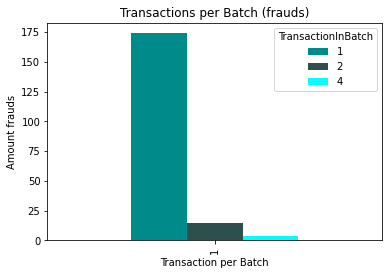

In [32]:
ax = pivot4.T.plot(kind='bar', ylabel='Amount frauds', xlabel= 'Transaction per Batch',title='Transactions per Batch (frauds)',color=['darkcyan','darkslategrey','cyan'])
#plt.xticks( [1,12,4] );


In [33]:
pivot6 = pd.pivot_table(data_train.query('FraudResult ==1'), values='TransactionId', index='AccountId', columns='FraudResult', aggfunc ='count')
pivot6 = pivot6[1].sort_values(ascending = False)
pivot6

AccountId
572     31
4421    22
1609    14
4003    12
1909     8
1873     7
4590     7
2656     7
4687     7
3337     6
1178     6
1959     5
523      4
4249     4
2366     3
953      3
3832     3
2043     2
3943     2
1825     2
1488     2
4004     2
4465     2
1208     2
830      2
530      2
4637     1
3692     1
3686     1
3636     1
3519     1
4655     1
3041     1
352      1
2461     1
2289     1
476      1
777      1
1240     1
1291     1
1317     1
1335     1
1480     1
1520     1
1605     1
1754     1
1823     1
1898     1
368      1
2123     1
2244     1
4841     1
Name: 1, dtype: int64

### Data Visualization

In [34]:
px.pie(data_train_clean.groupby('DebitCredit').count()[['TransactionId']].reset_index(), values = 'TransactionId', names ='DebitCredit',title='Percentage of Debit and Credit',color_discrete_sequence=px.colors.qualitative.Prism )

### Transform Data

In [35]:

# 9. Transform variable value (log) due to skewness
data_train_clean['ValueLog']=np.log(data_train_clean.Value)

### Dataframe for model

In [36]:
# Columns we used for the EDA but we don`t need them for our model==>Drop
cols_to_drop = ['Value','TransactionId', 'SubscriptionId']
df = data_train_clean.drop(columns=cols_to_drop, inplace=False)

In [37]:
# create Dummies for categorical variables
df = pd.get_dummies(df, columns = ['ProviderId', 'ProductId', 'ProductCategory', 'ChannelId', 'PricingStrategy', 'DayTime','TransactionWeekday','DebitCredit'], drop_first=True)

In [38]:
# create csv for model input
df.to_csv('data/data_train_clean_withdummies.csv', index = False)